# Notes

S&P 500 Start and End
Start = 2103.84
End = 5522.3


In [44]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cleanup HPI Data


In [45]:
# Load the Excel file
file_path = "data/HPI_not_seasonally_adjusted.xlsx"
sheet_name = "Montreal_CMA"

df = pd.read_excel(file_path, sheet_name=sheet_name)

# Make all column names lowercase
df.columns = df.columns.str.lower()

# Convert the date column to datetime format if it's not already
df["date"] = pd.to_datetime(df["date"])

# Filter the date range
START_DATE = "2015-07-01"
END_DATE = "2024-07-31"
date_mask = (df["date"] >= START_DATE) & (df["date"] <= END_DATE)
filtered_df = df.loc[date_mask]

# Select the composite_HPI column
df_hpi = filtered_df[["date", "composite_hpi"]]

# Visualize the HPI Data

Make note of specific points of interest.


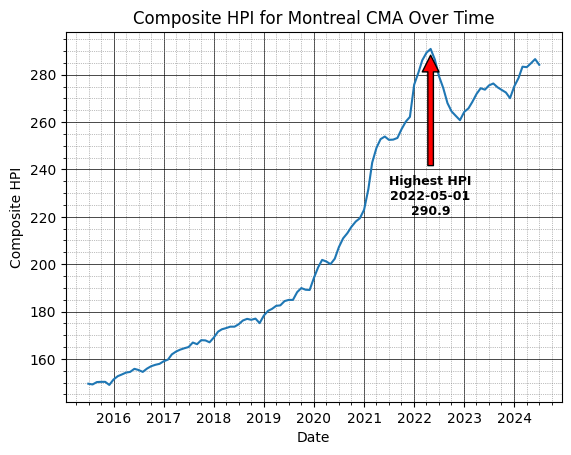

In [72]:
plt.plot(df_hpi["date"], df_hpi["composite_hpi"])
plt.title("Composite HPI for Montreal CMA Over Time")
plt.xlabel("Date")
plt.ylabel("Composite HPI")

# Add major grid lines
plt.grid(True, which="major", linestyle="-", linewidth="0.5", color="black")

# Add minor grid lines
plt.minorticks_on()
plt.grid(True, which="minor", linestyle=":", linewidth="0.5", color="gray")

# Find the date and value where composite_hpi is the highest
max_hpi_date = df_hpi.loc[df_hpi["composite_hpi"].idxmax(), "date"]
max_hpi_value = df_hpi["composite_hpi"].max()

# Annotate the highest HPI point
plt.annotate(
  f"Highest HPI\n{max_hpi_date.date()}\n{max_hpi_value}",
  xy=(max_hpi_date, max_hpi_value),
  xytext=(max_hpi_date, max_hpi_value - 70),
  arrowprops=dict(facecolor="red", shrink=0.05),
  fontsize=9,
  fontweight="bold",
  ha="center",
)

plt.show()

# Summarize the Investment Results

- Account for inflation
- Calculate the percent gains


In [71]:
# Account for Inflation
STARTING_VALUE = 1000
final_value_pre_inflation = 10_000

totalCPI_2015_07 = 127.3  # Consumer Price Index for July 2015
totalCPI_2024_06 = (
  161.4  # Consumer Price Index for June 2024 (Didn't have July 2024 data)
)

inflation_factor = totalCPI_2015_07 / totalCPI_2024_06

final_value_post_inflation = final_value_pre_inflation * inflation_factor

print(
  f"Final value post-inflation (Relative to July 2015): ${final_value_post_inflation:.2f}"
)

# Calculate the annualized rate of return
# years = 2024 - 2015 + 1
# annualized_return = (final_value_post_inflation / STARTING_VALUE) ** (1 / years) - 1
# print(f"Annualized rate of return: {annualized_return:.2%}")

# Calculate the percent gain (relative to July 2015)
percent_gain = ((final_value_post_inflation - STARTING_VALUE) / STARTING_VALUE) * 100
print(f"Percent gain (Relative to July 2015): {percent_gain:.2f}%")

Final value post-inflation (Relative to July 2015): $7887.24
Percent gain (Relative to July 2015): 688.72%
